# Installing/importing packages

In [ ]:
# Install required packages
!pip install datasets
!pip install evaluate
!pip install transformers[torch]
!pip install accelerate -U

In [ ]:
# Import required packages
import pandas as pd
from collections import Counter
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import torch

# Data processing - Nieuw

In [ ]:
from datasets import load_dataset

# Loading data from HF
yelp_reviews_dataset = load_dataset('yelp_review_full')
app_reviews_dataset = load_dataset('app_reviews')
product_reviews_dataset = load_dataset('generated_reviews_enth')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
yelp_reviews_dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 50000
    })
})

In [ ]:
app_reviews_dataset

DatasetDict({
    train: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 288065
    })
})

In [ ]:
product_reviews_dataset

DatasetDict({
    train: Dataset({
        features: ['translation', 'review_star', 'correct'],
        num_rows: 141369
    })
    validation: Dataset({
        features: ['translation', 'review_star', 'correct'],
        num_rows: 15708
    })
    test: Dataset({
        features: ['translation', 'review_star', 'correct'],
        num_rows: 17453
    })
})

In [ ]:
from datasets import concatenate_datasets

# Combine train, val, test data if needed
yelp_reviews = concatenate_datasets([yelp_reviews_dataset["train"], yelp_reviews_dataset["test"]])
app_reviews = app_reviews_dataset['train']
product_reviews = concatenate_datasets([product_reviews_dataset["train"], product_reviews_dataset["validation"], product_reviews_dataset["test"]])

In [ ]:
# Inspect data
print(product_reviews['translation'][0])

{'en': "I had a hard time finding a case for my new LG Lucid 2 but finally found this one on amazon. The colors are really pretty and it works just as well as, if not better than the otterbox. Hopefully there will be more available by next Xmas season. Overall, very cute case. I love cheetah's. :)", 'th': 'ฉันมีปัญหาในการหาเคสสำหรับ LG Lucid 2 ใหม่ของฉัน แต่ในที่สุดก็พบเคสนี้ใน Amazon สีสวยมากและใช้งานได้ดีเช่นเดียวกับถ้าไม่ดีกว่านาก หวังว่าจะมีให้มากขึ้นในช่วงเทศกาลคริสต์มาสหน้า โดยรวมแล้วน่ารักมาก ๆ ฉันรักเสือชีตาห์ :)'}


In [ ]:
# Rename columns
app_reviews = app_reviews.rename_column("review", "text")
app_reviews = app_reviews.rename_column("star", "label")

product_reviews = product_reviews.rename_column("translation", "text")
product_reviews = product_reviews.rename_column("review_star", "label")

In [ ]:
# Transform 'text' of product reviews to only get english translation
def extract_en(data):
  data['text'] = data['text']['en']
  return data

product_reviews = product_reviews.map(extract_en)

In [ ]:
# Inspect data
product_reviews['text'][0]

"I had a hard time finding a case for my new LG Lucid 2 but finally found this one on amazon. The colors are really pretty and it works just as well as, if not better than the otterbox. Hopefully there will be more available by next Xmas season. Overall, very cute case. I love cheetah's. :)"

## Convert stars to sentiment

In [ ]:
# Unique star labels
print(f"Yelp: {set(yelp_reviews['label'])}")    # 0-4 scale
print(f"App: {set(app_reviews['label'])}")      # 1-5 scale
print(f"Product: {set(app_reviews['label'])}")  # 1-5 scale

Yelp: {0, 1, 2, 3, 4}
App: {1, 2, 3, 4, 5}
Product: {1, 2, 3, 4, 5}


In [ ]:
# Function to convert stars to sentiment class 'positive', 'neutral', 'negative'
def transform_labels(data, max_star):
  if data['label'] <= (max_star-3):
      data['label_class'] = 'negative'
      data['label_class_num'] = 0
  elif data['label'] == (max_star-2):
      data['label_class'] = 'neutral'
      data['label_class_num'] = 1
  else:  # data['label'] is 3, 4 or 5 (depending on max stars)
      data['label_class'] = 'positive'
      data['label_class_num'] = 2
  return data

In [ ]:
# Convert labels to labels_new
yelp_reviews = yelp_reviews.map(transform_labels, fn_kwargs={'max_star': 4})
app_reviews = app_reviews.map(transform_labels, fn_kwargs={'max_star': 5})
product_reviews = product_reviews.map(transform_labels, fn_kwargs={'max_star': 5})

In [ ]:
# Inspect data
print(yelp_reviews['label_class'][0], yelp_reviews['text'][0])
print(app_reviews['label_class'][150], app_reviews['text'][150])
print(product_reviews['label_class'][100], product_reviews['text'][100])

positive dr. goldberg offers everything i look for in a general practitioner.  he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first.  really, what more do you need?  i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank.
neutral Great App. But Great App  actually it's the only one so far I found stable & never break down  an app which announce everything.. Except: ?)Clock time announce. ?) Battery low announce. If these options can be added it'll be the best ever for sure
negative This is the second battery charger I bought as a Christmas present, that came from Amazon, after one purchased before for my son. His was still working. The first charger, received in July, b

## Train-val-test split

In [ ]:
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

# Function to make train, val, test split of df and convert it back HF dataset object
def split_data(data):
  # Data to pandas
  df = data.to_pandas()

  # Split into train and intermediate set
  train_df, intermediate_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label_class'])

  # Split the intermediate set into validation and test sets
  validation_df, test_df = train_test_split(intermediate_df, test_size=0.5, random_state=42, stratify=intermediate_df['label_class'])

  # Convert DataFrames into Hugging Face Datasets
  datasets = {
      'train': Dataset.from_pandas(train_df),
      'validation': Dataset.from_pandas(validation_df),
      'test': Dataset.from_pandas(test_df)
  }

  # Create a single Hugging Face Dataset with splits
  dataset = DatasetDict(datasets).flatten()

  return dataset

In [ ]:
yelp_reviews = split_data(yelp_reviews)
yelp_reviews

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'label_class', 'label_class_num', '__index_level_0__'],
        num_rows: 490000
    })
    validation: Dataset({
        features: ['label', 'text', 'label_class', 'label_class_num', '__index_level_0__'],
        num_rows: 105000
    })
    test: Dataset({
        features: ['label', 'text', 'label_class', 'label_class_num', '__index_level_0__'],
        num_rows: 105000
    })
})

In [ ]:
app_reviews = split_data(app_reviews)
app_reviews

DatasetDict({
    train: Dataset({
        features: ['package_name', 'text', 'date', 'label', 'label_class', 'label_class_num', '__index_level_0__'],
        num_rows: 201645
    })
    validation: Dataset({
        features: ['package_name', 'text', 'date', 'label', 'label_class', 'label_class_num', '__index_level_0__'],
        num_rows: 43210
    })
    test: Dataset({
        features: ['package_name', 'text', 'date', 'label', 'label_class', 'label_class_num', '__index_level_0__'],
        num_rows: 43210
    })
})

In [ ]:
product_reviews = split_data(product_reviews)
product_reviews

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'correct', 'label_class', 'label_class_num', '__index_level_0__'],
        num_rows: 122171
    })
    validation: Dataset({
        features: ['text', 'label', 'correct', 'label_class', 'label_class_num', '__index_level_0__'],
        num_rows: 26179
    })
    test: Dataset({
        features: ['text', 'label', 'correct', 'label_class', 'label_class_num', '__index_level_0__'],
        num_rows: 26180
    })
})

## Force class balance train sets

### Yelp reviews

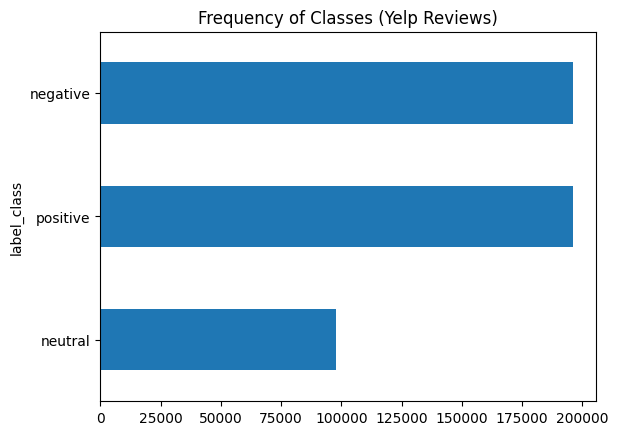

label_class
neutral      98000
positive    196000
negative    196000
Name: count, dtype: int64


In [ ]:
df_yelp_train = yelp_reviews['train'].to_pandas()
df_yelp_train['label_class'].value_counts(ascending=True).plot.barh()
plt.title('Frequency of Classes (Yelp Reviews)')
plt.show()

counts = df_yelp_train['label_class'].value_counts(ascending=True)
print(counts)

In [ ]:
from sklearn.utils import resample

# Funtion to undersample classes to min observations minority class
def undersample_classes(df):
  # Get the counts for each class
  counts = df['label_class'].value_counts()

  # Find the class with the least samples
  min_class_count = counts.min()

  # Create a list containing dataframes for each class
  dfs = [df[df['label_class'] == label] for label in counts.index]

  # Undersample each dataframe in the list to have min_class_count examples
  dfs_undersampled = [resample(df, replace=False, n_samples=min_class_count, random_state=42) for df in dfs]

  # Combine undersampled dataframes
  df_balanced = pd.concat(dfs_undersampled)

  # Shuffle for good measure
  df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)

  return df_balanced

In [ ]:
df_yelp_train_bal = undersample_classes(df_yelp_train)

In [ ]:
counts = df_yelp_train_bal['label_class'].value_counts(ascending=True)
print(counts)

label_class
negative    98000
neutral     98000
positive    98000
Name: count, dtype: int64


### App reviews

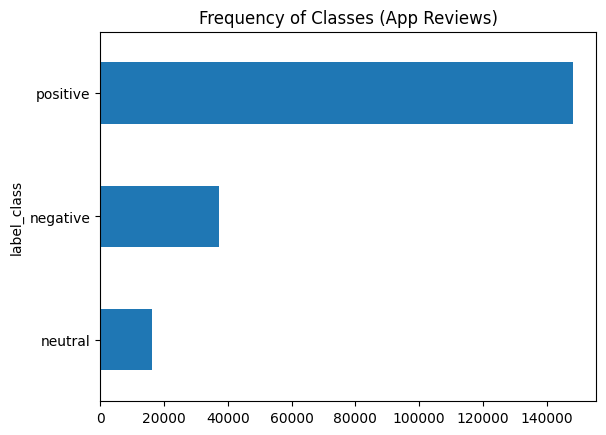

label_class
neutral      16237
negative     37274
positive    148134
Name: count, dtype: int64


In [ ]:
df_app_train = app_reviews['train'].to_pandas()
df_app_train['label_class'].value_counts(ascending=True).plot.barh()
plt.title('Frequency of Classes (App Reviews)')
plt.show()

counts = df_app_train['label_class'].value_counts(ascending=True)
print(counts)

In [ ]:
df_app_train_bal = undersample_classes(df_app_train)

In [ ]:
counts = df_app_train_bal['label_class'].value_counts(ascending=True)
print(counts)

label_class
negative    16237
positive    16237
neutral     16237
Name: count, dtype: int64


### Product reviews

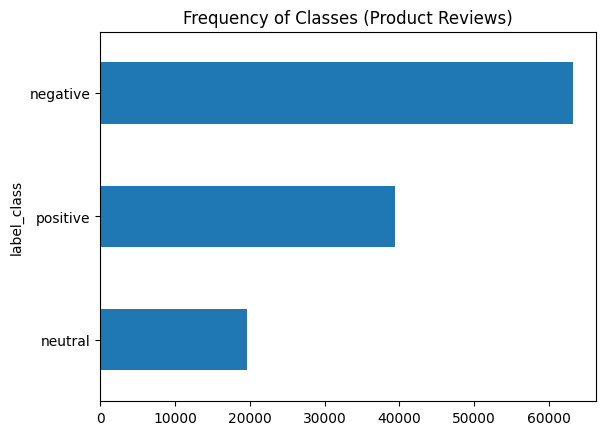

label_class
neutral     19626
positive    39376
negative    63169
Name: count, dtype: int64


In [ ]:
df_product_train = product_reviews['train'].to_pandas()
df_product_train['label_class'].value_counts(ascending=True).plot.barh()
plt.title('Frequency of Classes (Product Reviews)')
plt.show()

counts = df_product_train['label_class'].value_counts(ascending=True)
print(counts)

In [ ]:
df_product_train_bal = undersample_classes(df_product_train)

In [ ]:
counts = df_product_train_bal['label_class'].value_counts(ascending=True)
print(counts)

label_class
positive    19626
neutral     19626
negative    19626
Name: count, dtype: int64


## Equal training set sizes

In [ ]:
# Function to make sure all training sets have an equal number of observations
def sample_dfs(df1, df2, df3):
  min_rows = ((min(df1.shape[0], df2.shape[0], df3.shape[0])) / 3) -1 # Determine the minimum number of rows / 3 classes (-1 to round down)
  min_rows = int(round(min_rows, 0))

  df1_sampled = df1.groupby('label_class').apply(lambda x: x.sample(n=min_rows, random_state=42))
  df2_sampled = df2.groupby('label_class').apply(lambda x: x.sample(n=min_rows, random_state=42))
  df3_sampled = df3.groupby('label_class').apply(lambda x: x.sample(n=min_rows, random_state=42))

  return df1_sampled, df2_sampled, df3_sampled

In [ ]:
df_yelp_train_bal_sampled, df_app_train_bal_sampled, df_product_train_bal_sampled = sample_dfs(df_yelp_train_bal, df_app_train_bal, df_product_train_bal)

In [ ]:
counts = df_yelp_train_bal_sampled['label_class'].value_counts(ascending=True)
print('Yelp train:')
print(counts)

Yelp train:
label_class
negative    16236
neutral     16236
positive    16236
Name: count, dtype: int64


In [ ]:
counts = df_app_train_bal_sampled['label_class'].value_counts(ascending=True)
print('App train:')
print(counts)

App train:
label_class
negative    16236
neutral     16236
positive    16236
Name: count, dtype: int64


In [ ]:
counts = df_product_train_bal_sampled['label_class'].value_counts(ascending=True)
print('Product train:')
print(counts)

Product train:
label_class
negative    16236
neutral     16236
positive    16236
Name: count, dtype: int64


## Replace balanced and sampled training data

In [ ]:
# Replace new training set
def replace_train(dataset, df_train):
  new_train_dataset = Dataset.from_pandas(df_train[['text', 'label', 'label_class', 'label_class_num']])
  dataset['train'] = new_train_dataset
  return dataset

In [ ]:
yelp_reviews_final = replace_train(yelp_reviews, df_yelp_train_bal_sampled)
app_reviews_final = replace_train(app_reviews, df_app_train_bal_sampled)
product_reviews_final = replace_train(product_reviews, df_product_train_bal_sampled)

In [ ]:
# Inspect data to check if text and labels still match
print(yelp_reviews_final['train']['text'][48000])
print(yelp_reviews_final['train']['label'][48000])
print(yelp_reviews_final['train']['label_class'][48000])

Best steak ever. Lovely bottle of wine (under $50) and fantastic service. Overall, great romantic date place.
4
positive


In [ ]:
# Inspect data to check if text and labels still match
print(app_reviews_final['train']['text'][21000])
print(app_reviews_final['train']['label'][21000])
print(app_reviews_final['train']['label_class'][21000])

5 Star if a can send text to search box of Exodus
3
neutral


In [ ]:
# Inspect data to check if text and labels still match
print(product_reviews_final['train']['text'][20])
print(product_reviews_final['train']['label'][20])
print(product_reviews_final['train']['label_class'][20])

This company is a rip off. You can get it at almost any store for $2. Don't waste your money on their overpriced stuff. I'm shocked that the government has approved selling this in stores. Maybe it's better than some other products because its less toxic. Whatever you make of it, go and pick up some hydrogen peroxide. It'll kill all bugs within an hour...as long as the larvae are inside you.
1
negative


## Undersample datasets (keep original class balance)

In [ ]:
def undersample_data(dataset, set, samples):
  df = dataset[set].to_pandas()

  # Undersample test_set to n_samples, stratify=True
  df_undersampled = resample(df, replace=False, n_samples=samples, stratify=df, random_state=42)

  # Store new test dataset
  new_dataset = Dataset.from_pandas(df_undersampled[['text', 'label', 'label_class', 'label_class_num']])
  dataset[set] = new_dataset

  return dataset

In [ ]:
# Undersample train
yelp_reviews_final = undersample_data(yelp_reviews_final, 'train', 30000)
app_reviews_final = undersample_data(app_reviews_final, 'train', 30000)
product_reviews_final = undersample_data(product_reviews_final, 'train', 30000)

In [ ]:
# Undersample test
yelp_reviews_final = undersample_data(yelp_reviews_final, 'test', 10000)
app_reviews_final = undersample_data(app_reviews_final, 'test', 10000)
product_reviews_final = undersample_data(product_reviews_final, 'test', 10000)

In [ ]:
# Undersample val
yelp_reviews_final = undersample_data(yelp_reviews_final, 'validation', 10000)
app_reviews_final = undersample_data(app_reviews_final, 'validation', 10000)
product_reviews_final = undersample_data(product_reviews_final, 'validation', 10000)

## Drop and rename needed columns

In [ ]:
# Keep necessary columns
columns_to_keep = ['text', 'label_class', 'label_class_num']

def drop_and_rename_cols(dataset):
  # Drop
  dataset['train']  = dataset['train'].remove_columns([col for col in dataset['train'].column_names if col not in columns_to_keep])
  dataset['validation']  = dataset['validation'].remove_columns([col for col in dataset['validation'].column_names if col not in columns_to_keep])
  dataset['test']  = dataset['test'].remove_columns([col for col in dataset['test'].column_names if col not in columns_to_keep])

  # Rename
  dataset = dataset.rename_column("label_class_num", "label")
  dataset = dataset.rename_column("label_class", "label_text")

  return dataset

In [ ]:
yelp_reviews_final = drop_and_rename_cols(yelp_reviews_final)
app_reviews_final = drop_and_rename_cols(app_reviews_final)
product_reviews_final = drop_and_rename_cols(product_reviews_final)

In [ ]:
# Check final dataset
yelp_reviews_final

DatasetDict({
    train: Dataset({
        features: ['text', 'label_text', 'label'],
        num_rows: 30000
    })
    validation: Dataset({
        features: ['text', 'label_text', 'label'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['text', 'label_text', 'label'],
        num_rows: 10000
    })
})

In [ ]:
# Check final dataset
app_reviews_final

DatasetDict({
    train: Dataset({
        features: ['text', 'label_text', 'label'],
        num_rows: 30000
    })
    validation: Dataset({
        features: ['text', 'label_text', 'label'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['text', 'label_text', 'label'],
        num_rows: 10000
    })
})

In [ ]:
# Check final dataset
product_reviews_final

DatasetDict({
    train: Dataset({
        features: ['text', 'label_text', 'label'],
        num_rows: 30000
    })
    validation: Dataset({
        features: ['text', 'label_text', 'label'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['text', 'label_text', 'label'],
        num_rows: 10000
    })
})

# Zero-Shot

## Yelp reviews prediction

In [ ]:
# Test inputs
test_set = yelp_reviews_final['test']['text'][50:53]
print(test_set)

['I\'ve only been here once, but thought I\'d share after reading some other reviews. \\n\\nFirst off, this is NOT TexMex. I\'m not sure what I would classify it as, maybe AmeriMex, but definitely NOT TexMex. \\n\\nNow that I have that out of the way, I\'ll say that I like El Cancun. \\n\\nI do not like this El Cancun. \\n\\nWhile it looks decent on the outside and the inside, the food and service were simply terrible. Chicken was very watered down, the salsa was flavorless, and the service make a fast food chain look really good. Just a poor, poor experience at this location overall. If this was the only El Cancun in Charlotte, I would feel the same way many posters do and just never come back. \\n\\nLuckily for me, I live in Rock Hill. There\'s an El Cancun here. And it\'s pretty awesome. I won\'t give it a full on review because this isn\'t really the place for it, but suffice it to say that if you\'re in RH and you see the El Cancun and you go \\"ugh, no way that place is terrible\

In [ ]:
test_set_answ = yelp_reviews_final['test']['label_text'][50:53]
print(test_set_answ)

['negative', 'positive', 'neutral']


In [ ]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset

device = "cuda:0" if torch.cuda.is_available() else "cpu"  # Use GPU if available

# Load the zero-shot classifier
model_name = "typeform/distilbert-base-uncased-mnli"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)

# Define classifier
classifier = pipeline("zero-shot-classification",
                      model = model,
                      tokenizer = tokenizer,
                      device = device)

# Define candidate labels
candidate_labels = ['negative', 'neutral', 'positive']

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


In [ ]:
# Yelp predictions using zero-shot classifier
predictions = classifier(yelp_reviews_final['test']['text'], candidate_labels)

yelp_pred_label_text = []
yelp_pred_label = []

label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}

# Retrieve highest scoring label/class
for prediction in predictions:
  predicted_label_text = prediction['labels'][0]   # Prediction output auto sorts highest to largest scores, so 0 index is highest scoring label
  predicted_label = label_mapping[predicted_label_text]

  # Append labels to lists
  yelp_pred_label_text.append(predicted_label_text)
  yelp_pred_label.append(predicted_label)

In [ ]:
import csv
from google.colab import drive

# Save predictions to Google Drive
drive.mount('/content/drive')

# Save predictions to the CSV file
with open('/content/drive/My Drive/yelp_zero_shot_predictions.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Header row
    writer.writerow(['Review Text', 'Predicted Label Text', 'Predicted Label'])

    # Data rows
    for i in range(len(yelp_reviews_final['test']['text'])):
        writer.writerow([yelp_reviews_final['test']['text'][i],
                         yelp_pred_label_text[i],
                         yelp_pred_label[i]])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Score zero-shot
from sklearn.metrics import classification_report

y_true = yelp_reviews_final['test']['label']

df_pred = pd.read_csv('/content/drive/My Drive/yelp_zero_shot_predictions.csv')  # Retrieve predictions from csv
y_pred = df_pred['Predicted Label']

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.54      0.63      4083
           1       0.23      0.25      0.24      1989
           2       0.61      0.76      0.68      3928

    accuracy                           0.57     10000
   macro avg       0.53      0.52      0.52     10000
weighted avg       0.59      0.57      0.57     10000



## App reviews prediction

In [ ]:
# App predictions using zero-shot classifier
predictions = classifier(app_reviews_final['test']['text'], candidate_labels)

app_pred_label_text = []
app_pred_label = []

label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}

# Retrieve highest scoring label/class
for prediction in predictions:
    predicted_label_text = prediction['labels'][0]   # Prediction output auto sorts highest to largest scores, so 0 index is highest scoring label
    predicted_label = label_mapping[predicted_label_text]

    # Append labels to lists
    app_pred_label_text.append(predicted_label_text)
    app_pred_label.append(predicted_label)


In [ ]:
import csv
from google.colab import drive

# Save predictions to Google Drive
drive.mount('/content/drive')

# Save predictions to the CSV file
with open('/content/drive/My Drive/app_zero_shot_predictions.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Header row
    writer.writerow(['Review Text', 'Predicted Label Text', 'Predicted Label'])

    # Data rows
    for i in range(len(app_reviews_final['test']['text'])):
        writer.writerow([app_reviews_final['test']['text'][i],
                         app_pred_label_text[i],
                         app_pred_label[i]])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Score zero-shot
from sklearn.metrics import classification_report

y_true = app_reviews_final['test']['label']

df_pred = pd.read_csv('/content/drive/My Drive/app_zero_shot_predictions.csv')  # Retrieve predictions from csv
y_pred = df_pred['Predicted Label']

print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.61      0.51      0.56      1817
           1       0.12      0.09      0.10       759
           2       0.86      0.91      0.89      7424

    accuracy                           0.78     10000
   macro avg       0.53      0.51      0.52     10000
weighted avg       0.76      0.78      0.77     10000



## Product reviews prediction

In [ ]:
# Product predictions using zero-shot classifier
predictions = classifier(product_reviews_final['test']['text'], candidate_labels)

product_pred_label_text = []
product_pred_label = []

label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}

# Retrieve highest scoring label/class
for prediction in predictions:
    predicted_label_text = prediction['labels'][0]   # Prediction output auto sorts highest to largest scores, so 0 index is highest scoring label
    predicted_label = label_mapping[predicted_label_text]

    # Append labels to lists
    product_pred_label_text.append(predicted_label_text)
    product_pred_label.append(predicted_label)


In [ ]:
import csv
from google.colab import drive

# Save predictions to Google Drive
drive.mount('/content/drive')

# Save predictions to the CSV file
with open('/content/drive/My Drive/product_zero_shot_predictions.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Header row
    writer.writerow(['Review Text', 'Predicted Label Text', 'Predicted Label'])

    # Data rows
    for i in range(len(product_reviews_final['test']['text'])):
        writer.writerow([product_reviews_final['test']['text'][i],
                         product_pred_label_text[i],
                         product_pred_label[i]])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Score zero-shot
from sklearn.metrics import classification_report

y_true = product_reviews_final['test']['label']

df_pred = pd.read_csv('/content/drive/My Drive/product_zero_shot_predictions.csv')  # Retrieve predictions from csv
y_pred = df_pred['Predicted Label']

print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.80      0.58      0.67      5221
           1       0.16      0.12      0.14      1590
           2       0.54      0.87      0.67      3189

    accuracy                           0.60     10000
   macro avg       0.50      0.52      0.49     10000
weighted avg       0.62      0.60      0.59     10000



# Fine-tuned Yelp reviews (training)

In [ ]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, BertForSequenceClassification
from datasets import load_dataset

device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Loading model
model_name = "typeform/distilbert-base-uncased-mnli"
num_labels = 3
model = (AutoModelForSequenceClassification
         .from_pretrained(model_name, num_labels=3)
         .to(device))
tokenizer = AutoTokenizer.from_pretrained(model_name)

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


In [ ]:
import torch.nn as nn

# Adapt model for three labels
model.classifier = nn.Linear(model.config.hidden_size, 3)

In [ ]:
def tokenize_function(batch):
  text = batch["text"]
  return tokenizer(text, padding='max_length', truncation=True, max_length=256)

In [ ]:
yelp_reviews_final_encoded = yelp_reviews_final.map(tokenize_function, batched=True, batch_size=64)

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
yelp_reviews_final_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 30000
    })
    validation: Dataset({
        features: ['text', 'label_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['text', 'label_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 10000
    })
})

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    precision = precision_score(labels, preds, average="weighted")
    recall = recall_score(labels, preds, average="weighted")

    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }


In [ ]:
from transformers import TrainingArguments, Trainer

# Defining training args
batch_size = 32
logging_steps = len(yelp_reviews_final_encoded['train']) // batch_size
model_name_arg = f"{model_name}-finetuned-yelp"
training_args = TrainingArguments(output_dir=model_name_arg,
                                  num_train_epochs=3,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  load_best_model_at_end=True,
                                  log_level="error")

In [ ]:
trainer_yelp = Trainer(
    model=model,
    args=training_args,
    train_dataset=yelp_reviews_final_encoded['train'],
    eval_dataset=yelp_reviews_final_encoded['validation'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
trainer_yelp.train()

Epoch,Training Loss,Validation Loss


TypeError: '<' not supported between instances of 'str' and 'int'

#Fine-tuned App reviews (training)

In [ ]:
# Tokenize data
app_reviews_final_encoded = app_reviews_final.map(tokenize_function, batched=True, batch_size=64)

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
app_reviews_final_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 30000
    })
    validation: Dataset({
        features: ['text', 'label_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['text', 'label_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 10000
    })
})

In [ ]:
from transformers import TrainingArguments, Trainer

# Defining training args
batch_size = 32
logging_steps = len(app_reviews_final_encoded['train']) // batch_size
model_name_arg = f"{model_name}-finetuned-app"
training_args = TrainingArguments(output_dir=model_name_arg,
                                  num_train_epochs=3,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  load_best_model_at_end=True,
                                  log_level="error")

In [ ]:
trainer_app = Trainer(
    model=model,
    args=training_args,
    train_dataset=app_reviews_final_encoded['train'],
    eval_dataset=app_reviews_final_encoded['validation'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
trainer_app.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.812000,0.643396,0.758900,0.785888,0.826350,0.758900
2,0.702100,0.683189,0.727000,0.766709,0.830997,0.727000
3,0.631600,0.692230,0.732000,0.767503,0.824190,0.732000


TrainOutput(global_step=2814, training_loss=0.7150748900343699, metrics={'train_runtime': 699.0646, 'train_samples_per_second': 128.743, 'train_steps_per_second': 4.025, 'total_flos': 5961139246080000.0, 'train_loss': 0.7150748900343699, 'epoch': 3.0})

#Fine-tuned Product reviews (training)

In [ ]:
product_reviews_final_encoded = product_reviews_final.map(tokenize_function, batched=True, batch_size=64)

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
from transformers import TrainingArguments, Trainer

# Defining training args
batch_size = 32
logging_steps = len(product_reviews_final_encoded['train']) // batch_size
model_name_arg = f"{model_name}-finetuned-product"
training_args = TrainingArguments(output_dir=model_name_arg,
                                  num_train_epochs=3,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  load_best_model_at_end=True,
                                  log_level="error")

In [ ]:
trainer_product = Trainer(
    model=model,
    args=training_args,
    train_dataset=product_reviews_final_encoded['train'],
    eval_dataset=product_reviews_final_encoded['validation'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
trainer_product.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.670800,0.502829,0.787800,0.790207,0.792971,0.787800
2,0.504900,0.540892,0.770100,0.786391,0.819514,0.770100
3,0.413400,0.572886,0.768700,0.785889,0.822910,0.768700


TrainOutput(global_step=2814, training_loss=0.5298344059539503, metrics={'train_runtime': 712.4728, 'train_samples_per_second': 126.321, 'train_steps_per_second': 3.95, 'total_flos': 5961139246080000.0, 'train_loss': 0.5298344059539503, 'epoch': 3.0})

# Performance fine-tuned models on test sets

## Fine-tuned Yelp

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def compute_metrics(pred):
    labels = pred['label_ids']
    # If your predictions are logits (raw outputs from model), you'll need to apply argmax.
    # If they are already class indices, you can skip the argmax step.
    preds = pred['predictions'].argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    precision = precision_score(labels, preds, average="weighted", zero_division=0)
    recall = recall_score(labels, preds, average="weighted", zero_division=0)

    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }


**Yelp on Yelp**

In [ ]:
# Tuned yelp on yelp set
preds_tuned_yelp_on_yelp_test = trainer_yelp.predict(yelp_reviews_final_encoded['test'])
preds_tuned_yelp_on_yelp_test.metrics

NameError: name 'trainer_yelp' is not defined

In [ ]:
# Accessing elements by index for a tuple return type
predictions = preds_tuned_yelp_on_yelp_test[0]
label_ids = preds_tuned_yelp_on_yelp_test[1]
# The first element is the raw predictions (logits)
# The second element is the label IDs,
pred_tuned_yelp_on_yelp = {
    'predictions': predictions,
    'label_ids': label_ids
}
scores_tuned_yelp_on_yelp = compute_metrics(pred_tuned_yelp_on_yelp)
# Print the custom metrics
print(scores_tuned_yelp_on_yelp)

{'accuracy': 0.7624, 'f1': 0.7777192062725786, 'precision': 0.8132917574072961, 'recall': 0.7624}


**Yelp on App**

In [ ]:
# Tuned yelp on app set
preds_tuned_yelp_on_app_test = trainer_yelp.predict(app_reviews_final_encoded['test'])
preds_tuned_yelp_on_app_test.metrics

{'test_loss': 0.7535462379455566,
 'test_accuracy': 0.6754,
 'test_f1': 0.7156636431683326,
 'test_precision': 0.7907947148912822,
 'test_recall': 0.6754,
 'test_runtime': 74.2393,
 'test_samples_per_second': 134.7,
 'test_steps_per_second': 4.216}

In [ ]:
# Accessing elements by index for a tuple return type
predictions_yelp_on_app = preds_tuned_yelp_on_app_test[0]
label_ids_yelp_on_app = preds_tuned_yelp_on_app_test[1]
# The first element is the raw predictions (logits)
# The second element is the label IDs,
pred_yelp_on_app = {
    'predictions': predictions_yelp_on_app,
    'label_ids': label_ids_yelp_on_app
}
scores_yelp_on_app = compute_metrics(pred_yelp_on_app)
# Print the custom metrics
print(scores_yelp_on_app)


{'accuracy': 0.6754, 'f1': 0.7156636431683326, 'precision': 0.7907947148912822, 'recall': 0.6754}


**Yelp on Product**

In [ ]:
# Tuned yelp on product set
preds_tuned_yelp_on_product_test = trainer_yelp.predict(product_reviews_final_encoded['test'])
preds_tuned_yelp_on_product_test.metrics

{'test_loss': 0.7175279259681702,
 'test_accuracy': 0.6801,
 'test_f1': 0.7123204002082916,
 'test_precision': 0.7898235128382661,
 'test_recall': 0.6801,
 'test_runtime': 75.5914,
 'test_samples_per_second': 132.29,
 'test_steps_per_second': 4.141}

In [ ]:
# Accessing elements by index for a tuple return type
predictions_yelp_on_product = preds_tuned_yelp_on_product_test[0]
label_ids_yelp_on_product = preds_tuned_yelp_on_product_test[1]
# The first element is the raw predictions (logits)
# The second element is the label IDs,
pred_yelp_on_product = {
    'predictions': predictions_yelp_on_product,
    'label_ids': label_ids_yelp_on_product
}
scores_yelp_on_product = compute_metrics(pred_yelp_on_product)
# Print the custom metrics
print(scores_yelp_on_product)


{'accuracy': 0.6801, 'f1': 0.7123204002082916, 'precision': 0.7898235128382661, 'recall': 0.6801}


## Fine-tuned App

**App on App**

In [ ]:
# Predictions on the app reviews test set
preds_tuned_app_on_app_test = trainer_app.predict(app_reviews_final_encoded['test'])
preds_tuned_app_on_app_test.metrics

{'test_loss': 0.6522344946861267,
 'test_accuracy': 0.7567,
 'test_f1': 0.7851687098917554,
 'test_precision': 0.8277145166740673,
 'test_recall': 0.7567,
 'test_runtime': 24.9745,
 'test_samples_per_second': 400.409,
 'test_steps_per_second': 12.533}

In [ ]:
# Accessing elements by index for a tuple return type
predictions_app_on_app = preds_tuned_app_on_app_test[0]
label_ids_app_on_app = preds_tuned_app_on_app_test[1]
# The first element is the raw predictions (logits)
# The second element is the label IDs,
pred_app_on_app = {
    'predictions': predictions_app_on_app,
    'label_ids': label_ids_app_on_app
}
scores_app_on_app = compute_metrics(pred_app_on_app)
# Print the custom metrics
print(scores_app_on_app)

{'accuracy': 0.7567, 'f1': 0.7851687098917554, 'precision': 0.8277145166740673, 'recall': 0.7567}


**App on Yelp**

In [ ]:
# Tuned app on yelp set
preds_tuned_app_on_yelp_test = trainer_app.predict(yelp_reviews_final_encoded['test'])
preds_tuned_app_on_yelp_test.metrics

{'test_loss': 0.7901890873908997,
 'test_accuracy': 0.6056,
 'test_f1': 0.6271471618646064,
 'test_precision': 0.7630474953195813,
 'test_recall': 0.6056,
 'test_runtime': 27.6829,
 'test_samples_per_second': 361.234,
 'test_steps_per_second': 11.307}

In [ ]:
# Accessing elements by index for a tuple return type
predictions_app_on_yelp = preds_tuned_app_on_yelp_test[0]
label_ids_app_on_yelp = preds_tuned_app_on_yelp_test[1]
# The first element is the raw predictions (logits)
# The second element is the label IDs,
pred_app_on_yelp = {
    'predictions': predictions_app_on_yelp,
    'label_ids': label_ids_app_on_yelp
}
scores_app_on_yelp = compute_metrics(pred_app_on_yelp)
# Print the custom metrics
print(scores_app_on_yelp)


{'accuracy': 0.6056, 'f1': 0.6271471618646064, 'precision': 0.7630474953195813, 'recall': 0.6056}


**App on Product**

In [ ]:
# Tuned app on product set
preds_tuned_app_on_product_test = trainer_app.predict(product_reviews_final_encoded['test'])
preds_tuned_app_on_product_test.metrics

{'test_loss': 0.9456729292869568,
 'test_accuracy': 0.5327,
 'test_f1': 0.5630394663130017,
 'test_precision': 0.7817784946932784,
 'test_recall': 0.5327,
 'test_runtime': 25.0382,
 'test_samples_per_second': 399.39,
 'test_steps_per_second': 12.501}

In [ ]:
# Accessing elements by index for a tuple return type
predictions_app_on_product = preds_tuned_app_on_product_test[0]
label_ids_app_on_product = preds_tuned_app_on_product_test[1]
# The first element is the raw predictions (logits)
# The second element is the label IDs,
pred_app_on_product = {
    'predictions': predictions_app_on_product,
    'label_ids': label_ids_app_on_product
}
scores_app_on_product = compute_metrics(pred_app_on_product)
# Print the custom metrics
print(scores_app_on_product)


{'accuracy': 0.5327, 'f1': 0.5630394663130017, 'precision': 0.7817784946932784, 'recall': 0.5327}


## Fine-tuned Product

**Product on Product**

In [ ]:
# Predictions on the product reviews test set
preds_tuned_product_on_product_test = trainer_product.predict(product_reviews_final_encoded['test'])
preds_tuned_product_on_product_test.metrics

{'test_loss': 0.4986144006252289,
 'test_accuracy': 0.7895,
 'test_f1': 0.7915513911600687,
 'test_precision': 0.793918453196783,
 'test_recall': 0.7895,
 'test_runtime': 25.4607,
 'test_samples_per_second': 392.762,
 'test_steps_per_second': 12.293}

In [ ]:
# Accessing elements by index for a tuple return type
predictions_product_on_product = preds_tuned_product_on_product_test[0]
label_ids_product_on_product = preds_tuned_product_on_product_test[1]
# The first element is the raw predictions (logits)
# The second element is the label IDs,
pred_product_on_product = {
    'predictions': predictions_product_on_product,
    'label_ids': label_ids_product_on_product
}
scores_product_on_product = compute_metrics(pred_product_on_product)
# Print the custom metrics
print(scores_product_on_product)


{'accuracy': 0.7895, 'f1': 0.7915513911600687, 'precision': 0.793918453196783, 'recall': 0.7895}


**Product on Yelp**

In [ ]:
# Tuned product on yelp set
preds_tuned_product_on_yelp_test = trainer_product.predict(yelp_reviews_final_encoded['test'])
preds_tuned_product_on_yelp_test.metrics

{'test_loss': 0.5951917767524719,
 'test_accuracy': 0.7496,
 'test_f1': 0.7408329247755171,
 'test_precision': 0.7362724087839024,
 'test_recall': 0.7496,
 'test_runtime': 27.6987,
 'test_samples_per_second': 361.027,
 'test_steps_per_second': 11.3}

In [ ]:
# Accessing elements by index for a tuple return type
predictions_product_on_yelp = preds_tuned_product_on_yelp_test[0]
label_ids_product_on_yelp = preds_tuned_product_on_yelp_test[1]
# The first element is the raw predictions (logits)
# The second element is the label IDs,
pred_product_on_yelp = {
    'predictions': predictions_product_on_yelp,
    'label_ids': label_ids_product_on_yelp
}
scores_product_on_yelp = compute_metrics(pred_product_on_yelp)
# Print the custom metrics
print(scores_product_on_yelp)


{'accuracy': 0.7496, 'f1': 0.7408329247755171, 'precision': 0.7362724087839024, 'recall': 0.7496}


**Product on App**

In [ ]:
# Tuned product on app set
preds_tuned_product_on_app_test = trainer_product.predict(app_reviews_final_encoded['test'])
preds_tuned_product_on_app_test.metrics

{'test_loss': 0.7379652857780457,
 'test_accuracy': 0.7251,
 'test_f1': 0.743593948999537,
 'test_precision': 0.7847082476816891,
 'test_recall': 0.7251,
 'test_runtime': 33.179,
 'test_samples_per_second': 301.396,
 'test_steps_per_second': 9.434}

In [ ]:
# Accessing elements by index for a tuple return type
predictions_product_on_app = preds_tuned_product_on_app_test[0]
label_ids_product_on_app = preds_tuned_product_on_app_test[1]
# The first element is the raw predictions (logits)
# The second element is the label IDs,
pred_product_on_app = {
    'predictions': predictions_product_on_app,
    'label_ids': label_ids_product_on_app
}
scores_product_on_app = compute_metrics(pred_product_on_app)
# Print the custom metrics
print(scores_product_on_app)


{'accuracy': 0.7251, 'f1': 0.743593948999537, 'precision': 0.7847082476816891, 'recall': 0.7251}


# Plots

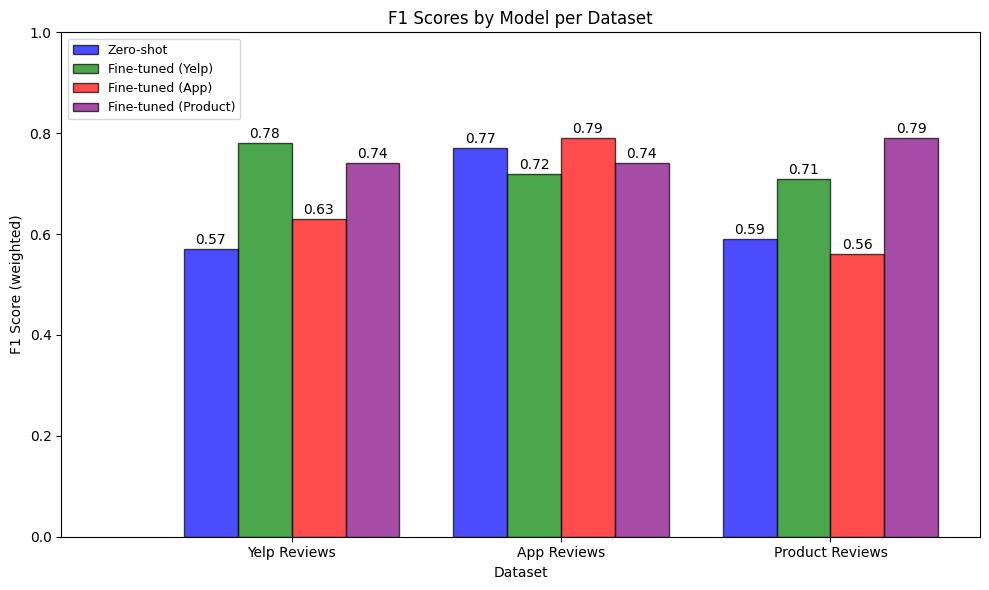

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# F1 scores for each model across three datasets
f1_scores = {
    'Zero-shot': [0.57, 0.77, 0.59],
    'Fine-tuned (Yelp)': [0.78, 0.72, 0.71],
    'Fine-tuned (App)': [0.63, 0.79, 0.56],
    'Fine-tuned (Product)': [0.74, 0.74, 0.79]
}

# Datasets
datasets = ['Yelp Reviews', 'App Reviews', 'Product Reviews']

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))


# Set width of bars
bar_width = 0.2

# Set up positions for the bars
index = np.arange(len(datasets))

# Define colors for the bars
colors = ['blue', 'green', 'red', 'purple']

models = list(f1_scores.keys())
handles = []  # to store custom legend handles
for i, model in enumerate(models):
    bar = plt.bar(index + i * bar_width, f1_scores[model], bar_width, label=model, color=colors[i], alpha=0.7, edgecolor='black')
    handles.append(bar[0])  # append the bar as a custom legend handle
    for j, score in enumerate(f1_scores[model]):
        plt.text(index[j] + i * bar_width, score + 0.01, str(score), ha='center')

# Plot an invisible bar to use as a custom legend handle
invisible_bar = plt.bar(0, 0, color='white', hatch='', alpha=0)
handles.append(invisible_bar[0])

# Create legend with custom handles
plt.legend(handles, models + [''], loc='upper right')



# Labeling
ax.set_xlabel('Dataset')
ax.set_ylabel('F1 Score (weighted)')
ax.set_title('F1 Scores by Model per Dataset')
ax.set_xticks(index + bar_width * (len(models) - 1) / 2)
ax.set_xticklabels(datasets)
ax.set_ylim(0, 1)  # Set y-axis limit to 1
ax.legend(loc='upper left', prop={'size': 9})  # Adjust legend size

plt.tight_layout()

plt.show()
